# AT-BLSTM for IMbd62

In [1]:
# Start GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import print_function
import os
import re
import sys
import pandas as pd
import numpy as np

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
import pandas as pd
import keras.layers as layers
import tensorflow as tf
import tensorflow_hub as hub
import pydot
import itertools
import h5py
import keras.callbacks
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.regularizers import l2
from AdamW import AdamW
from SGDW import SGDW
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Flatten, merge
from keras.models import Model
from keras.callbacks import CSVLogger
from keras.layers import Conv1D, MaxPooling1D,AveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import TimeDistributed, Bidirectional, Lambda
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [5]:
from keras.models import Model
from keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

In [6]:
# Load nltk 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.classify.scikitlearn import SklearnClassifier
%matplotlib inline

In [7]:
batch_size = 32 
maxlen = 512
max_sentences = 15
w_l2 = 1e-4
nb_classes = 60

In [8]:
def preProcessText(text):
    """
    Function to pre-process the tweet
    """
    #str(tweet.encode('utf-8')) 
    str(text)
    #Replace all words preceded by '@' with 'USER_NAME'
    text  = re.sub(r'@[^\s]+', 'USER_NAME', text)  
    #Replace all url's with 'URL'
    text  = re.sub(r'www.[^\s]+ | http[^\s]+',' URL ', text)
    #Replace all hashtags with the word
    text  = text.strip('#')
    #Replace words with long repeated characters with the shorter form
    text  = re.sub(r'(.)\1{2,}', r'\1', text)
    #Remove any extra white space
    text = re.sub(r'[\s]+', ' ', text)
    return text

In [9]:
def striphtml(s):
    p = re.compile(r'<.*?>')
    return p.sub("", str(s))
def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [10]:
# Import dataset
datasource = '../../data/'
data = pd.read_csv(datasource + 'cleanimbd62.zip')
data.dropna(subset=['text'], inplace=True)
data.dropna(subset=['userId'], inplace=True)
data.head(3)

,Unnamed: 0,text,reviewId,userId
0,0,somebody call peta ! i caught glimpses of this...,490485,syl
1,1,just awful ! mail rosie a mussel to shut her b...,490043,syl
2,2,it's not for me ! i just hated it ! after only...,490772,syl


In [11]:
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [13]:
# Drop any duplication text 
data.drop_duplicates(subset='text', inplace=True)
data.reset_index(drop=True, inplace=True)

In [14]:
data.head(3)

,text,reviewId,userId
0,somebody call peta ! i caught glimpses of this...,490485,syl
1,just awful ! mail rosie a mussel to shut her b...,490043,syl
2,it's not for me ! i just hated it ! after only...,490772,syl


# Empirical distribution of word in the article

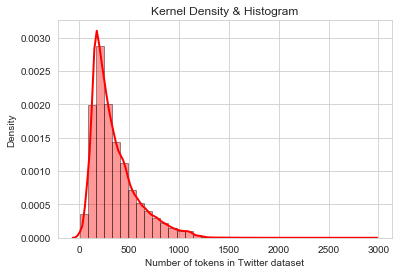

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
df = data['text'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.round(df.mean() + df.std()).astype(int)
sns.distplot(df, hist=True, kde=True, bins=int(180/5), color='red', 
             hist_kws={'edgecolor':'black'},kde_kws={'linewidth':2})
# plt.axvline(x=max_seq_len, color='k', label='max len')
plt.title('Kernel Density & Histogram')
plt.xlabel('Number of tokens in Twitter dataset')
plt.ylabel('Density')
# plt.savefig(source + 'image/word_dist_imbd62.png')
plt.show()
plt.close('all')

In [15]:
# from sklearn.neighbors import KernelDensity
# kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
# kde.fit(df[:, None])
# logprob = kde.score_samples

In [16]:
txt = ''
docs = []
sentences = []
labels = []
for cont, label in zip(data.text, data.userId):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', 
                         preProcessText(clean(striphtml(cont))))
    sentences = [sent.lower() for sent in sentences]
    docs.append(sentences)
    labels.append(label)

In [17]:
num_sent = []
for doc in docs:
    num_sent.append(len(doc))
    for s in doc:
        txt += s

In [18]:
chars = sorted(list(set(txt)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 67


In [19]:
print (len(docs)), print(len(chars))

61937
67


(None, None)

In [20]:
print('Doing One hot encoding for training sample and targets:')
X = np.ones((len(docs), max_sentences, maxlen), dtype=np.int64) * -1
y = np.array(labels)
for i, doc in enumerate(docs):
    for j, sentence in enumerate(doc):
        if j < max_sentences:
            for t, char in enumerate(sentence[-maxlen:]):
                X[i, j, (maxlen - 1 - t)] = char_indices[char]             

Doing One hot encoding for training sample and targets:


In [21]:
print('Sample Input Data:{}'.format(X[1,1]))

Sample Input Data:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
print(y.shape)

(61937, 60)


# Attention layer

In [24]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [25]:
class AttentionWithContext(Layer):
   
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Precision, Recall and F-Score Script

In [7]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tensor board

In [8]:
# tensorbd_dir = 'drive/My Drive/Colab Notebooks/imbd62/'
model_save_dir = '../../save_models/imbd62/'
tensorboard = TensorBoard(log_dir=model_save_dir+'./imbd62_AT-BLSTM_No_CNN_logs',
                         histogram_freq=0, 
                          write_graph=True, 
                         write_images=True)

# Callback

In [9]:
reduce_lr_adam = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                                   patience=5,min_lr=1e-4)
reduce_lr_sgd = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,patience=5, min_lr=1e-5)

# Earlystop and others

In [10]:
# EarlyStopping
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,verbose=1,
                                          mode='auto')
num_epochs = 30
#checkpointer
checkpointer = ModelCheckpoint(model_save_dir+'_AT-BLSTM_No_CNN.hdf5', 
                               monitor='val_acc', 
                               verbose=1, save_best_only=True,
                               mode='max')
# CSV logger keras
csv_logger = CSVLogger(model_save_dir+'_AT-BLSTM_No_CNN.csv', 
                       append=True, separator=';')

# Splitting data

In [32]:
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

validation_split = 0.2
nb_validation_sample = int(validation_split * len(X))

x_train = X[:-nb_validation_sample]
y_train = y[:-nb_validation_sample]

x_test = X[-nb_validation_sample:]
y_test = y[-nb_validation_sample:]

print("Training shape", x_train.shape)
print('Training label shape:', y_train.shape)

print("Test shape", x_test.shape)
print('Test label shape:', y_test.shape)

Training shape (49550, 15, 512)
Training label shape: (49550, 60)
Test shape (12387, 15, 512)
Test label shape: (12387, 60)


# Convolutional layer with filter, windows and pooling

In [30]:
# Convolutional layer parameter
filter_length = [5, 3, 3]
nb_filter = [196, 196, 256]
pool_length = 5

In [31]:
# sentence input
in_sentence = Input(shape=(maxlen,),
                    dtype='int64',name='main_input1')
# document input
document = Input(shape=(max_sentences, maxlen), 
                 dtype='int64',name='main_input2')

In [32]:
def binarize(x, sz=70):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))
def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 70

In [37]:
embedded = Lambda(binarize, output_shape=binarize_outshape, 
                  name='embed_input')(in_sentence)

In [38]:
from keras import initializers
from keras.initializers import glorot_normal, normal

# Encoding Layer

In [39]:
# embedded: encodes sentence
for i in range(len(nb_filter)):
    embedded = Conv1D(filters=nb_filter[i],
                      kernel_size=filter_length[i],
                      padding='valid',
                      activation='relu',
                      kernel_initializer=initializers.glorot_uniform(seed=0),
                      bias_initializer='zeros',strides=1)(embedded)

    embedded = Dropout(0.1)(embedded)
    embedded = MaxPooling1D(pool_size=pool_length)(embedded)

bi_lstm_sent = \
    Bidirectional(LSTM(64,return_sequences=False,
                       name='blstm_input1'))(embedded)
sent_encode = Dropout(0.3)(bi_lstm_sent)
encoder = Model(inputs=in_sentence, outputs=sent_encode)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input1 (InputLayer)     (None, 512)               0         
_________________________________________________________________
embed_input (Lambda)         (None, 512, 70)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 508, 196)          68796     
_________________________________________________________________
dropout_5 (Dropout)          (None, 508, 196)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 101, 196)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 99, 196)           115444    
_________________________________________________________________
dropout_6 (Dropout)          (None, 99, 196)           0   

# Decoder Layer

In [40]:
def build_cnn():
    encoded = TimeDistributed(encoder)(document)
    # encoded: sentences to bi-lstm for document encoding 
    b_lstm_doc = \
        Bidirectional(LSTM(256,return_sequences=True))(encoded)
    output = AttentionWithContext()(b_lstm_doc)
    output = Dense(64, activation='relu')(output)
    output = Dropout(0.1)(output)    
    output = Dense(nb_classes, activation='softmax')(output)
    model = Model(inputs=document, outputs=output)
    model.summary()
    return model

# Training with AdamW 
  * from: https://github.com/shaoanlu/AdamW-and-SGDW

In [34]:
# Adam parameter
model = build_cnn()
b, B, T = batch_size, x_train.shape[0], num_epochs
wd = 0.005 * (b/B/T)**0.5
model.compile(loss='categorical_crossentropy',
                optimizer=AdamW(weight_decay=wd),metrics=['accuracy',f1])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 128)           499376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 512)           788480    
_________________________________________________________________
attention_with_context_1 (At (None, 512)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3900

In [35]:
# save model
model.save_weights(model_save_dir+"saved_IMBD62_model.h5")

In [37]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
    with tf.device('/gpu:0'):
        history_imbd62_atten = model.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,verbose=1,
                               callbacks=[reduce_lr_adam,earlystop,csv_logger,checkpointer])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39640 samples, validate on 9910 samples
Epoch 1/25
39640/39640 [==============================] - 656s 17ms/step - loss: 3.3636 - acc: 0.1275 - f1: 0.0126 - val_loss: 3.0038 - val_acc: 0.1998 - val_f1: 0.0334

Epoch 00001: val_acc improved from -inf to 0.19980, saving model to ../../save_models/imbd62/imbd62.hdf5
Epoch 2/25
39640/39640 [==============================] - 651s 16ms/step - loss: 2.9015 - acc: 0.2227 - f1: 0.0762 - val_loss: 2.7194 - val_acc: 0.2678 - val_f1: 0.1244

Epoch 00002: val_acc improved from 0.19980 to 0.26781, saving model to ../../save_models/imbd62/imbd62.hdf5
Epoch 3/25
39640/39640 [==============================] - 653s 16ms/step - loss: 2.6673 - acc: 0.2717 - f1: 0.1446 - val_loss: 2.5317 - val_acc: 0.3105 - val_f1: 0.1970

Epoch 00003: val_acc improved from 0.26781 to 0.31049,

In [38]:
#Print average acc
average_acc = np.mean(history_imbd62_atten.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_imbd62_atten.history['val_acc'])
print(average_val_acc)
print("------------")

0.8606163807541605
------------
0.9600235452044102
------------


In [39]:
#Print average loss
average_loss = np.mean(history_imbd62_atten.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_imbd62_atten.history['val_loss'])
print(average_val_loss)
print("------------")

0.4525036085821786
------------
0.17502620066636707
------------


In [101]:
#Print average f1-score
average_f1 = np.mean(history_imbd62_atten.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_imbd62_atten.history['val_f1'])
print(average_val_f1)
print("------------")

0.8620430235324626
------------
0.9583128726085429
------------


In [37]:
# Load model
model.load_weights('../../save_models/imbd62/imbd62.hdf5')

In [38]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 128)           499376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 512)           788480    
_________________________________________________________________
attention_with_context_1 (At (None, 512)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3900

In [25]:
# Evaluate the Model on the 20% Validation Dataset
# score =  model.evaluate(val_data, val_lab, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [39]:
# Evaluate the Model on the 20% Test Dataset
scorev =  model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scorev[0])
print('Test accuracy:', scorev[1])

12387/12387 [==============================] - 80s 6ms/step
Test loss:  2.1150212303685767
Test accuracy: 0.5574392508322923


In [40]:
x_test.shape

(12387, 15, 512)

In [41]:
prediction_value = model.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_test, axis=1)

In [51]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       194
           1       0.24      0.21      0.22       194
           2       0.55      0.62      0.58       223
           3       0.58      0.52      0.55       194
           4       0.55      0.51      0.53       196
           5       0.59      0.55      0.57       223
           6       0.88      0.87      0.87       196
           7       0.32      0.29      0.31       215
           8       0.59      0.64      0.61       186
           9       0.64      0.63      0.63       219
          10       0.41      0.47      0.44       196
          11       0.46      0.45      0.46       211
          12       0.70      0.69      0.69       187
          13       0.36      0.39      0.37       192
          14       0.68      0.76      0.72       192
          15       0.20      0.14      0.16       221
          16       0.38      0.40      0.39       178
          17       0.35    

# Plot

In [43]:
modelsource = '../../save_models/imbd62/'
df_movies = pd.read_csv(modelsource +'/imbd62.csv',engine='python',sep=';')
df_movies.to_excel(modelsource+'/imbd622.xlsx',engine='xlsxwriter')

In [41]:
df_movies.head(50)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.122906,0.009903,3.372167,0.001000,0.185166,0.022209,3.053170
1,1,0.212916,0.067544,2.947748,0.001000,0.262563,0.113077,2.736918
2,2,0.273083,0.141457,2.678178,0.001000,0.301816,0.177107,2.565543
3,3,0.316221,0.194618,2.511846,0.001000,0.353784,0.234512,2.376815
4,4,0.364985,0.265862,2.322807,0.001000,0.402725,0.309116,2.193539
5,5,0.417508,0.342557,2.129178,0.001000,0.437235,0.369204,2.055101
6,6,0.462563,0.406155,1.947617,0.001000,0.478507,0.436450,1.914750
7,7,0.503330,0.464246,1.780616,0.001000,0.491423,0.458616,1.844201
8,8,0.538623,0.508788,1.648717,0.001000,0.509082,0.490572,1.784769
9,9,0.566044,0.546306,1.530669,0.001000,0.513724,0.499606,1.770262


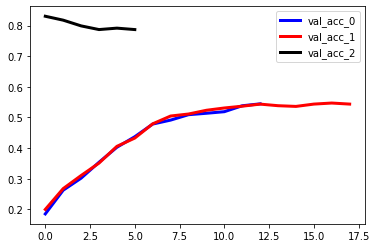

In [72]:
import matplotlib.pyplot as plt
plt.plot(range(13),df_movies.loc[:12,'val_acc'].values,color='blue',label= 'val_acc_0',linewidth=3)
plt.plot(range(18),df_movies.loc[13:30,'val_acc'].values,color='r',label= 'val_acc_1',linewidth=3)
plt.plot(range(6),df_movies.loc[31:36,'val_acc'].values,color='k',label= 'val_acc_2',linewidth=3)
plt.legend()
plt.show()

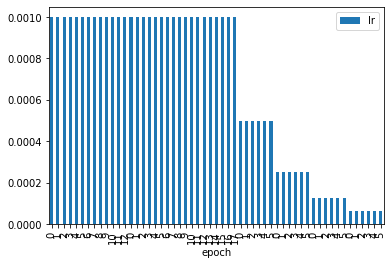

In [76]:
df_movies.plot('epoch','lr',kind='bar')

# Training accuracy and validate 4 IMbd62

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1, 'AT-BLSTM model accouracy for IMBD62')

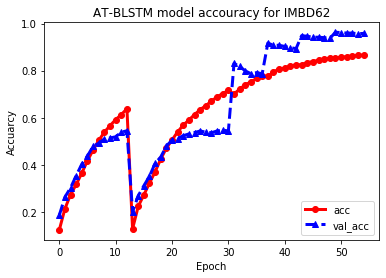

In [48]:
plt.plot(df_movies.index, df_movies['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_movies.index, df_movies['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'imdb62_acc.png')
plt.title('AT-BLSTM model accouracy for IMBD62')

# Training loss and validate 4 IMbd62

Text(0.5, 1, 'AT-BLSTM model loss for IMBD62')

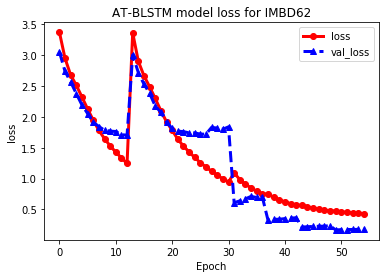

In [63]:
plt.plot(df_movies.index, df_movies['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_movies.index, df_movies['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'imdb62_loss.png')
plt.title('AT-BLSTM model loss for IMBD62')

# F1-Score

Text(0.5, 1, 'AT-BLSTM model F-score for IMBD62')

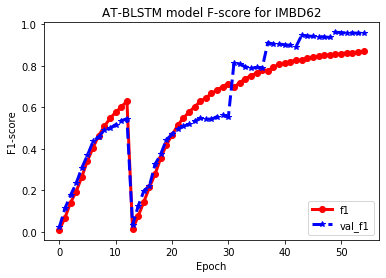

In [64]:
plt.plot(df_movies.index, df_movies['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_movies.index, df_movies['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'imdb62_F1-score.png')
plt.title('AT-BLSTM model F-score for IMBD62')

# Training SGDW

In [38]:
from keras.optimizers import SGD
epochs = 80
model_SGDW = build_cnn()
b, B, T = batch_size, x_train.shape[0], epochs
wd = 0.0025 * (b/B/T)**0.5

model_SGDW.compile(loss='categorical_crossentropy',
                 optimizer=SGDW(weight_decay=wd, momentum=0.9),
                 metrics=['accuracy',f1])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 128)           499376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 512)           788480    
_________________________________________________________________
attention_with_context_1 (At (None, 512)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3900

In [39]:
# save model
model_SGDW.save_weights(model_save_dir+"saved_IMBD62_model_SGDW.h5")

In [40]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
    history_imbd62_SGDW = model_SGDW.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=epochs,verbose=1,
                               callbacks=[reduce_lr_sgd,earlystop,csv_logger,checkpointer])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39640 samples, validate on 9910 samples
Epoch 1/80
39640/39640 [==============================] - 1184s 30ms/step - loss: 3.9342 - acc: 0.0434 - f1: 0.0000e+00 - val_loss: 3.5060 - val_acc: 0.0837 - val_f1: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.08365, saving model to ../../save_models/imbd62/imbd62_SGDW.hdf5
Epoch 2/80
39640/39640 [==============================] - 1168s 29ms/step - loss: 3.4130 - acc: 0.1031 - f1: 0.0010 - val_loss: 3.2583 - val_acc: 0.1264 - val_f1: 0.0020

Epoch 00002: val_acc improved from 0.08365 to 0.12644, saving model to ../../save_models/imbd62/imbd62_SGDW.hdf5
Epoch 3/80
39640/39640 [==============================] - 1168s 29ms/step - loss: 3.2202 - acc: 0.1478 - f1: 0.0074 - val_loss: 3.1403 - val_acc: 0.1576 - val_f1: 0.0178

Epoch 00003: val_acc improved fro

# Result

In [42]:
    #Print average acc
    average_acc = np.mean(history_imbd62_SGDW.history['acc'])
    print(average_acc)
    print("------------")
    #Print average val_acc
    average_val_acc = np.mean(history_imbd62_SGDW.history['val_acc'])
    print(average_val_acc)
    print("------------")

0.7387991927322057
------------
0.835378405707395
------------


In [43]:
#Print average loss
average_loss = np.mean(history_imbd62_SGDW.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_imbd62_SGDW.history['val_loss'])
print(average_val_loss)
print("------------")

0.8698424120615759
------------
0.5785822398234327
------------


In [44]:
#Print average f1-score
average_f1 = np.mean(history_imbd62_SGDW.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_imbd62_SGDW.history['val_f1'])
print(average_val_f1)
print("------------")

0.7385827528215441
------------
0.8310282009677618
------------


In [46]:
# Evaluate the Model on the 20% Test Dataset
scorev =  model_SGDW.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scorev[0])
print('Test accuracy:', scorev[1])

12387/12387 [==============================] - 80s 6ms/step
Test loss:  1.6841987279345494
Test accuracy: 0.5756841850351015


In [47]:
prediction_value = model_SGDW.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_test, axis=1)

# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

              precision    recall  f1-score   support

           0       0.49      0.66      0.56       194
           1       0.24      0.25      0.25       194
           2       0.61      0.61      0.61       223
           3       0.61      0.51      0.56       194
           4       0.67      0.49      0.57       196
           5       0.63      0.54      0.58       223
           6       0.88      0.91      0.90       196
           7       0.44      0.34      0.39       215
           8       0.67      0.63      0.65       186
           9       0.61      0.61      0.61       219
          10       0.41      0.52      0.46       196
          11       0.41      0.46      0.43       211
          12       0.78      0.76      0.77       187
          13       0.36      0.51      0.42       192
          14       0.72      0.72      0.72       192
          15       0.28      0.19      0.22       221
          16       0.32      0.34      0.33       178
          17       0.34    

In [49]:
modelsource = '../../save_models/imbd62/'
df_movies_SGD = pd.read_csv(modelsource +'/imbd62_SGDW.csv',
                        engine='python',
                        sep=';')

In [50]:
df_movies_SGD.head(3)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.044324,0.000049,3.929590,0.01,0.083249,0.000000,3.502074
1,1,0.104970,0.001025,3.407480,0.01,0.128153,0.002153,3.252075
2,2,0.149294,0.007889,3.215264,0.01,0.164379,0.016268,3.120912


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1, 'AT-BLSTM model accouracy for IMBD62')

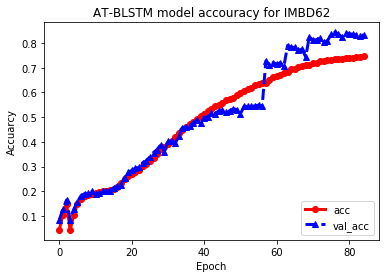

In [52]:
plt.plot(df_movies.index, df_movies['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_movies.index, df_movies['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'imdb62_SGDW_acc.png')
plt.title('AT-BLSTM model accouracy for IMBD62')

Text(0.5, 1, 'AT-BLSTM model loss for IMBD62')

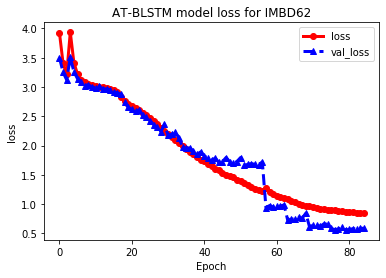

In [53]:
plt.plot(df_movies.index, df_movies['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_movies.index, df_movies['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'imdb62_SGDW_loss.png')
plt.title('AT-BLSTM model loss for IMBD62')

Text(0.5, 1, 'AT-BLSTM model F-score for IMBD62')

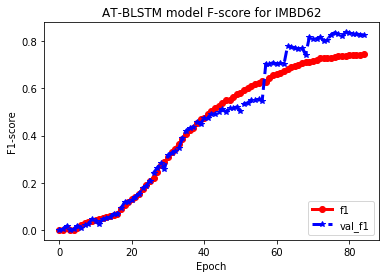

In [54]:
plt.plot(df_movies.index, df_movies['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_movies.index, df_movies['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'imdb62_SGDW_F1-score.png')
plt.title('AT-BLSTM model F-score for IMBD62')

# AT-BLSTM without convolutional layer

In [1]:
# Start GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from keras import backend as K
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [12]:
# Attention Layer
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [13]:
MAX_WORD_LENGTH = 512#7
MAX_WORDS = 15#10
MAX_NB_CHARS = 1000
EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.2

In [14]:
# Data
def preProcessText(text):
    """
    Function to pre-process the tweet
    """
    #str(tweet.encode('utf-8')) 
    str(text)
    #Replace all words preceded by '@' with 'USER_NAME'
    text  = re.sub(r'@[^\s]+', 'USER_NAME', text)  
    #Replace all url's with 'URL'
    text  = re.sub(r'www.[^\s]+ | http[^\s]+',' URL ', text)
    #Replace all hashtags with the word
    text  = text.strip('#')
    #Replace words with long repeated characters with the shorter form
    text  = re.sub(r'(.)\1{2,}', r'\1', text)
    #Remove any extra white space
    text = re.sub(r'[\s]+', ' ', text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    return text

In [15]:
# Import dataset
datasource = '../../data/'
data = pd.read_csv(datasource + 'cleanimbd62.zip')
data.dropna(subset=['text'], inplace=True)
data.dropna(subset=['userId'], inplace=True)
data.head(3)

data.drop(["Unnamed: 0"], axis=1, inplace=True)
# Drop any duplication text 
data.drop_duplicates(subset='text', inplace=True)
data.reset_index(drop=True, inplace=True)

In [16]:
data.head(3)

,text,reviewId,userId
0,somebody call peta ! i caught glimpses of this...,490485,syl
1,just awful ! mail rosie a mussel to shut her b...,490043,syl
2,it's not for me ! i just hated it ! after only...,490772,syl


In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data['userId'])
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
label = onehot_encoder.fit_transform(integer_encoded)

/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [18]:
data['text'] = data['text'].apply(preProcessText)

In [19]:
text = data['text']
sentences = text.apply(lambda x: x.split())

In [20]:
tokenizer = Tokenizer(num_words=MAX_NB_CHARS, char_level=True)
tokenizer.fit_on_texts(sentences.values)

In [21]:
data = np.zeros((len(sentences), MAX_WORDS, 
                 MAX_WORD_LENGTH), dtype='int32')
for i, words in enumerate(sentences):
    for j, word in enumerate(words):
        if j < MAX_WORDS:
            k = 0
            for _, char in enumerate(word):
                try:
                    if k < MAX_WORD_LENGTH:
                        if tokenizer.word_index[char] < MAX_NB_CHARS:
                            data[i, j, k] = tokenizer.word_index[char]
                            k=k+1
                except:
                    None
#                     print (char)

In [22]:
char_index = tokenizer.word_index
print('Total %s unique tokens.' % len(char_index))

Total 182587 unique tokens.


In [23]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', label.shape)

Shape of data tensor: (61937, 15, 512)
Shape of label tensor: (61937, 60)


In [24]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
label = label[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = label[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = label[-nb_validation_samples:]

print('Number training and validation set')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Number training and validation set
[ 806.  806.  777.  806.  803.  777.  802.  784.  811.  781.  804.  789.
  813.  803.  806.  775.  821.  791.  800.  797.  786.  785.  800.  802.
  799.  801.  810.  826. 1567.  793.  795.  814.  802.  822.  800.  795.
  798.  806.  791.  800.  796.  810.  779.  785.  805.  806.  796.  809.
  819.  800.  806. 1608.  791.  807.  791.  792.  793.  808.  808.  797.]
[194. 194. 223. 194. 196. 223. 196. 215. 186. 219. 196. 211. 187. 192.
 192. 221. 178. 209. 198. 202. 214. 215. 200. 198. 201. 199. 190. 174.
 433. 207. 205. 186. 196. 178. 200. 205. 180. 194. 205. 200. 204. 189.
 221. 215. 193. 190. 204. 191. 181. 200. 194. 392. 208. 193. 209. 208.
 202. 192. 192. 203.]


# Model

In [25]:
# ROCAUC
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [26]:
nb_classes = 60

In [27]:
embedding_layer = Embedding(len(char_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_WORD_LENGTH,
                            trainable=True)

char_input = Input(shape=(MAX_WORD_LENGTH,), dtype='int32')
char_sequences = embedding_layer(char_input)
char_lstm = Bidirectional(LSTM(100, return_sequences=True))(char_sequences)
char_dense = TimeDistributed(Dense(200))(char_lstm)
char_att = AttentionWithContext()(char_dense)
charEncoder = Model(char_input, char_att)

words_input = Input(shape=(MAX_WORDS, MAX_WORD_LENGTH), dtype='int32')
words_encoder = TimeDistributed(charEncoder)(words_input)
words_lstm = Bidirectional(LSTM(100, return_sequences=True))(words_encoder)
words_dense = TimeDistributed(Dense(200))(words_lstm)
words_att = AttentionWithContext()(words_dense)
preds = Dense(nb_classes, activation='softmax')(words_att)
model = Model(words_input, preds)

In [28]:
# EarlyStopping
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,verbose=1,
                                          mode='auto')
num_epochs = 30
batch_size = 128
#checkpointer
checkpointer = ModelCheckpoint(model_save_dir+'_AT-BLSTM_No_CNN2.hdf5', 
                               monitor='val_acc', 
                               verbose=1, save_best_only=True,
                               mode='max')
# CSV logger keras
csv_logger = CSVLogger(model_save_dir+'_AT-BLSTM_No_CNN2.csv', 
                       append=True, separator=';')

In [29]:
b, B, T = batch_size, x_train.shape[0], num_epochs
wd = 0.005 * (b/B/T)**0.5
model.compile(loss='categorical_crossentropy',
                optimizer=AdamW(weight_decay=wd),metrics=['accuracy',f1])

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 512)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200)           23635064  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 200)           240800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 200)           40200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                12060     
Total params: 23,968,524
Trainable params: 23,968,524
Non-trainable params: 0
_______________________________________________

In [31]:
model.save_weights(model_save_dir+"saved_IMBD62withoutCNN2.h5")
RocAuc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)

In [32]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
    history_imbd62_attenwithoutcnn = model.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,verbose=1,
                               callbacks=[reduce_lr_adam,earlystop,csv_logger,
                                          RocAuc,checkpointer])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39640 samples, validate on 9910 samples
Epoch 1/30
39640/39640 [==============================] - 2045s 52ms/step - loss: 3.9575 - acc: 0.0528 - f1: 0.0089 - val_loss: 3.6427 - val_acc: 0.1027 - val_f1: 0.0289

 ROC-AUC - epoch: 1 - score: 0.729967 


Epoch 00001: val_acc improved from -inf to 0.10272, saving model to ../../save_models/imbd62/_AT-BLSTM_No_CNN2.hdf5
Epoch 2/30
39640/39640 [==============================] - 2050s 52ms/step - loss: 3.4904 - acc: 0.1360 - f1: 0.0583 - val_loss: 3.3538 - val_acc: 0.1589 - val_f1: 0.0566

 ROC-AUC - epoch: 2 - score: 0.786564 


Epoch 00002: val_acc improved from 0.10272 to 0.15893, saving model to ../../save_models/imbd62/_AT-BLSTM_No_CNN2.hdf5
Epoch 3/30
39640/39640 [==============================] - 2059s 52ms/step - loss: 3.2758 - acc: 0.1790 - f1: 0.0888 - 

In [33]:
#Print average acc
average_acc = np.mean(history_imbd62_attenwithoutcnn.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_imbd62_attenwithoutcnn.history['val_acc'])
print(average_val_acc)
print("------------")

0.8379406323538778
------------
0.751954254986179
------------


In [34]:
#Print average loss
average_loss = np.mean(history_imbd62_attenwithoutcnn.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_imbd62_attenwithoutcnn.history['val_loss'])
print(average_val_loss)
print("------------")

0.660908163941913
------------
0.8631067515411964
------------


In [35]:
#Print average f1-score
average_f1 = np.mean(history_imbd62_attenwithoutcnn.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_imbd62_attenwithoutcnn.history['val_f1'])
print(average_val_f1)
print("------------")

0.8309013601505029
------------
0.7467316634595653
------------


In [37]:
# Evaluate the Model on the 20% Test Dataset
scorev =  model.evaluate(x_val, y_val, verbose=1)
print('Test loss: ', scorev[0])
print('Test accuracy:', scorev[1])

12387/12387 [==============================] - 226s 18ms/step
Test loss:  6.004708119759868
Test accuracy: 0.2362153870993784


In [ ]:
prediction_value = model.predict(x_val)
predict_class = np.argmax(prediction_value, axis=-1)
y_val_integer = np.argmax(y_val, axis=1)

# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_val_integer, predict_class))

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [39]:
modelsource = '../../save_models/imbd62/'
df_imbd62_attenwithoutcnn = pd.read_csv(modelsource +'/_AT-BLSTM_No_CNN2.csv',
                        engine='python',
                        sep=';')

In [40]:
df_imbd62_attenwithoutcnn.head(3)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.052825,0.008913,3.957489,0.001,0.102725,0.028907,3.642702
1,1,0.135974,0.058349,3.490383,0.001,0.158930,0.056621,3.353773
2,2,0.178961,0.088841,3.275777,0.001,0.193946,0.091896,3.206858


Text(0.5, 1, 'ATT-BiLSTM model accuracy for IMBD62')

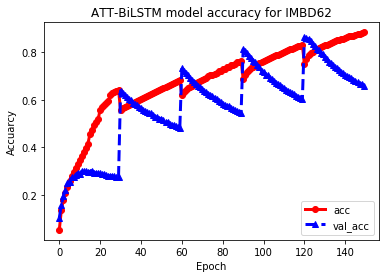

In [41]:
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'imbd62_attenwithoutcnn.png')
plt.title('ATT-BiLSTM model accuracy for IMBD62')

Text(0.5, 1, 'ATT-BiLSTM model loss for IMBD62')

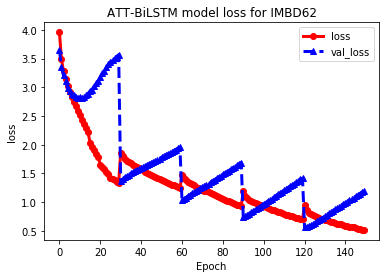

In [43]:
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'df_imbd62_attenwithoutcnn.png')
plt.title('ATT-BiLSTM model loss for IMBD62')

Text(0.5, 1, 'ATT-BiLSTM model F-score for IMBD62')

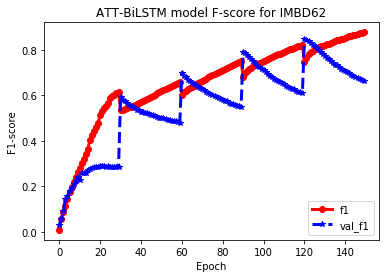

In [42]:
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_imbd62_attenwithoutcnn.index, df_imbd62_attenwithoutcnn['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'df_imbd62_attenwithoutcnn_F-score.png')
plt.title('ATT-BiLSTM model F-score for IMBD62')